In [15]:
import numpy as np
import pandas as pd
from psutil import virtual_memory

import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

In [83]:
virtual_memory()

svmem(total=16701882368, available=13136490496, percent=21.3, used=3019767808, free=10993975296, active=3776409600, inactive=1428193280, buffers=103006208, cached=2585133056, shared=227782656, slab=203530240)

# 1) Get the data

In [3]:
DATA_PATH = '/home/victor/Aero_TFG/analysedData/'
OUT_PATH = '/home/victor/Aero_TFG/modelIn/'

In [4]:
df = pd.read_csv(DATA_PATH + 'signal.csv', sep='|')

In [5]:
for c in df.columns:
    if 'float' in str(df[c].dtype):
        df[c] = pd.to_numeric(df[c], downcast='float')
    elif 'int' in str(df[c].dtype):
        df[c] = pd.to_numeric(df[c], downcast='integer')

In [6]:
virtual_memory()

svmem(total=16701882368, available=14421532672, percent=13.7, used=1773322240, free=13251952640, active=1913446400, inactive=1082175488, buffers=77959168, cached=1598648320, shared=196608000, slab=184680448)

In [7]:
df.head()

,FL_DATE,HOUR,OD_PAIR,DEP_DELAY,ARR_DELAY,MEDIAN_ARR_DELAY,MEDIAN_DEP_DELAY,DAY,DAY_OF_WEEK,QUARTER,YEAR,SEASON
0,2018-01-01,0,ANC_SEA,"[12.0, -10.0]",[],NaN,1.0,1,0,1,2018,2
1,2018-01-01,0,ATL_AUS,NaN,NaN,NaN,NaN,1,0,1,2018,2
2,2018-01-01,0,ATL_BNA,NaN,NaN,NaN,NaN,1,0,1,2018,2
3,2018-01-01,0,ATL_BOS,"[14.0, -4.0]","[-9.0, -15.0, 86.0]",-9.0,5.0,1,0,1,2018,2
4,2018-01-01,0,ATL_BWI,NaN,NaN,NaN,NaN,1,0,1,2018,2


In [8]:
df.drop(columns=['DEP_DELAY', 'ARR_DELAY'], inplace=True)

In [9]:
od_pairs = np.array(sorted(df['OD_PAIR'].unique()))
dates = np.array(sorted(df['FL_DATE'].unique()))
df.drop(columns=['FL_DATE'], inplace=True)
hours = np.array(sorted(df['HOUR'].unique()))
od_pairs.shape

(344,)

### Airports

In [62]:
df_nodes = pd.read_csv(DATA_PATH + 'airport_delays.csv', sep='|')
nodes = np.array(sorted(df_nodes['NODE'].unique()))

In [60]:
df_nodes.shape

(620736, 6)

In [61]:
df_nodes.head()

,FL_DATE,HOUR,NODE,MEDIAN_NODE_DELAY,MEDIAN_NODE_DEP_DELAY,MEDIAN_NODE_ARR_DELAY
0,2018-01-01,0,ANC,1.0,1.0,NaN
1,2018-01-01,0,ATL,-3.0,-2.0,-10.0
2,2018-01-01,0,AUS,-1.0,-1.0,1.5
3,2018-01-01,0,BNA,NaN,NaN,NaN
4,2018-01-01,0,BOS,1.0,9.5,0.0


# 2) Getting all OD pairs and nodes information

In [32]:
med_delays_odpairs = df['MEDIAN_DEP_DELAY'].values.reshape(-1, od_pairs.shape[0]).astype(np.float32)

In [64]:
df_od_med_delays = pd.DataFrame(med_delays_odpairs, columns=od_pairs)
df_od_med_delays.head(10)

,ANC_SEA,ATL_AUS,ATL_BNA,ATL_BOS,ATL_BWI,ATL_CLT,ATL_CMH,ATL_DCA,ATL_DEN,ATL_DFW,...,SLC_PHX,SLC_SEA,SMF_LAX,SMF_SAN,SMF_SEA,SNA_PHX,SNA_SJC,STL_ATL,STL_LGA,TPA_ATL
0,1.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,-7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,...,-2.0,NaN,1.0,NaN,-2.0,NaN,NaN,NaN,NaN,NaN
6,-6.0,NaN,NaN,NaN,3.0,NaN,NaN,NaN,3.0,-9.0,...,NaN,-7.0,-7.0,NaN,-1.0,-1.0,55.0,NaN,NaN,-1.0
7,NaN,NaN,NaN,-7.0,-4.0,-6.0,NaN,NaN,NaN,-3.0,...,-6.5,NaN,12.5,92.5,10.0,-6.0,6.0,-4.0,49.5,-3.5
8,-2.0,8.0,NaN,-3.5,-4.5,-4.0,-2.0,-1.0,0.0,9.5,...,NaN,12.5,-4.0,4.0,0.0,NaN,101.0,26.0,29.0,-3.0
9,-1.0,NaN,NaN,27.0,-4.0,-1.0,7.0,-2.0,0.0,-1.5,...,-1.0,NaN,2.0,NaN,53.0,10.5,0.0,-6.5,NaN,-0.5


In [76]:
med_delays_nodes_dep = df_nodes['MEDIAN_NODE_DEP_DELAY'].values.reshape(-1, nodes.shape[0]).astype(np.float32)
med_delays_nodes_arr = df_nodes['MEDIAN_NODE_ARR_DELAY'].values.reshape(-1, nodes.shape[0]).astype(np.float32)

In [77]:
cols_dep = [n + '_DEPAR' for n in nodes]
cols_arr = [n + '_ARRIV' for n in nodes]

df_node_med_delays = pd.concat([pd.DataFrame(med_delays_nodes_dep, columns=cols_dep),
                                pd.DataFrame(med_delays_nodes_arr, columns=cols_arr)], axis=1)
df_node_med_delays.head(10)

,ANC_DEP,ATL_DEP,AUS_DEP,BNA_DEP,BOS_DEP,BUR_DEP,BWI_DEP,CLE_DEP,CLT_DEP,CMH_DEP,...,SAT_ARR,SEA_ARR,SFO_ARR,SJC_ARR,SJU_ARR,SLC_ARR,SMF_ARR,SNA_ARR,STL_ARR,TPA_ARR
0,1.0,-2.0,-1.0,NaN,9.5,NaN,14.0,NaN,-4.0,NaN,...,NaN,-13.0,-4.0,NaN,24.0,17.0,51.0,NaN,NaN,NaN
1,12.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-8.0,-0.5,NaN,2.0,NaN,NaN,NaN,NaN,NaN
2,17.5,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.0,NaN,...,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,27.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-18.0,NaN,NaN,NaN,NaN,NaN
5,-7.0,54.0,-4.0,NaN,-9.0,NaN,NaN,NaN,-7.0,-1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,-6.0,-6.0,-10.0,-7.5,-1.0,NaN,4.0,-1.0,-1.0,83.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49.0
7,NaN,-2.5,-3.0,-3.5,-1.0,113.0,-1.0,-5.5,-5.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,10.5,-1.0,53.0,NaN,13.0,0.5,7.5,-1.0,-4.0,8.5,...,NaN,NaN,NaN,NaN,NaN,-10.0,NaN,0.0,NaN,NaN
9,25.0,47.5,20.0,-3.5,-4.0,1.5,-3.0,0.0,-4.0,-4.0,...,-15.0,NaN,NaN,NaN,39.0,NaN,NaN,8.0,1.0,NaN


In [ ]:
df_med_delays = pd.concat([df_od_med_delays, df_node_med_delays], axis=1)

In [79]:
assert len(df_od_med_delays) == len(df_node_med_delays) == len(df_med_delays) == dates.shape[0]*hours.shape[0]

# 3) Handle NaNs by interpolating or zero padding

In [68]:
med_nans = df_med_delays.isna().sum()
med_nans

ANC_SEA    4411
ATL_AUS    6510
ATL_BNA    5650
ATL_BOS    4438
ATL_BWI    4599
           ... 
SNA_PHX    6348
SNA_SJC    5776
STL_ATL    6124
STL_LGA    6375
TPA_ATL    4213
Length: 344, dtype: int64

In [35]:
LIMIT_INT = 6
NO_INT_HOUR = 4

In [44]:
init_nan = df_med_delays.isna()
init_nan.head(10)

,ANC_SEA_MED_DELAY,ATL_AUS_MED_DELAY,ATL_BNA_MED_DELAY,ATL_BOS_MED_DELAY,ATL_BWI_MED_DELAY,ATL_CLT_MED_DELAY,ATL_CMH_MED_DELAY,ATL_DCA_MED_DELAY,ATL_DEN_MED_DELAY,ATL_DFW_MED_DELAY,...,SLC_PHX_MED_DELAY,SLC_SEA_MED_DELAY,SMF_LAX_MED_DELAY,SMF_SAN_MED_DELAY,SMF_SEA_MED_DELAY,SNA_PHX_MED_DELAY,SNA_SJC_MED_DELAY,STL_ATL_MED_DELAY,STL_LGA_MED_DELAY,TPA_ATL_MED_DELAY
0,False,True,True,False,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
1,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
2,False,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
3,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
4,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
5,False,True,True,True,True,True,True,True,False,True,...,False,True,False,True,False,True,True,True,True,True
6,False,True,True,True,False,True,True,True,False,False,...,True,False,False,True,False,False,False,True,True,False
7,True,True,True,False,False,False,True,True,True,False,...,False,True,False,False,False,False,False,False,False,False
8,False,False,True,False,False,False,False,False,False,False,...,True,False,False,False,False,True,False,False,False,False
9,False,True,True,False,False,False,False,False,False,False,...,False,True,False,True,False,False,False,False,True,False


In [45]:
df_med_delays_int = df_med_delays.interpolate(limit=LIMIT_INT)
df_med_delays_int.head(10)

,ANC_SEA_MED_DELAY,ATL_AUS_MED_DELAY,ATL_BNA_MED_DELAY,ATL_BOS_MED_DELAY,ATL_BWI_MED_DELAY,ATL_CLT_MED_DELAY,ATL_CMH_MED_DELAY,ATL_DCA_MED_DELAY,ATL_DEN_MED_DELAY,ATL_DFW_MED_DELAY,...,SLC_PHX_MED_DELAY,SLC_SEA_MED_DELAY,SMF_LAX_MED_DELAY,SMF_SAN_MED_DELAY,SMF_SEA_MED_DELAY,SNA_PHX_MED_DELAY,SNA_SJC_MED_DELAY,STL_ATL_MED_DELAY,STL_LGA_MED_DELAY,TPA_ATL_MED_DELAY
0,1.0,NaN,NaN,5.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.5,NaN,NaN,3.285714,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.0,NaN,NaN,1.571429,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-1.0,NaN,NaN,-0.142857,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-4.0,NaN,NaN,-1.857143,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,-7.0,NaN,NaN,-3.571429,NaN,NaN,NaN,NaN,-1.0,NaN,...,-2.00,NaN,1.0,NaN,-2.0,NaN,NaN,NaN,NaN,NaN
6,-6.0,NaN,NaN,-5.285714,3.0,NaN,NaN,NaN,3.0,-9.0,...,-4.25,-7.00,-7.0,NaN,-1.0,-1.00,55.0,NaN,NaN,-1.0
7,-4.0,NaN,NaN,-7.000000,-4.0,-6.0,NaN,NaN,1.5,-3.0,...,-6.50,2.75,12.5,92.5,10.0,-6.00,6.0,-4.0,49.5,-3.5
8,-2.0,8.0,NaN,-3.500000,-4.5,-4.0,-2.0,-1.0,0.0,9.5,...,-3.75,12.50,-4.0,4.0,0.0,2.25,101.0,26.0,29.0,-3.0
9,-1.0,14.0,NaN,27.000000,-4.0,-1.0,7.0,-2.0,0.0,-1.5,...,-1.00,2.75,2.0,2.5,53.0,10.50,0.0,-6.5,20.5,-0.5


# 4) Clustering

In [50]:
df_med_delays_int.fillna(0, inplace=True)

In [55]:
# Apply clustering to each hour
n_clust = 6
random_state = 42
n_hours = dates.shape[0]*hours.shape[0]
kmeans_h = KMeans(n_clusters=n_clust, random_state=42)

kmeans_h.fit(df_med_delays_int.values)
df_med_delays['HOUR_CLUSTER'] = kmeans_h.labels_

In [57]:
# Apply clustering to each day
n_clust = 6
random_state = 42
kmeans_d = KMeans(n_clusters=n_clust, random_state=42)

kmeans_d.fit(df_med_delays_int.values.reshape(dates.shape[0], -1))
df_med_delays['DAY_CLUSTER'] = np.repeat(kmeans_d.labels_, hours.shape[0])

In [58]:
df_med_delays['DAY_CLUSTER-1'] = df_med_delays['DAY_CLUSTER'].shift(-hours.shape[0]*od_pairs.shape[0], fill_value=1)

# 5) Saving the data

In [80]:
df_med_delays['FL_DATE'] = np.repeat(dates, hours.shape[0])
df_med_delays['HOUR'] = np.tile(hours, dates.shape[0])

In [82]:
df_med_delays.to_csv(OUT_PATH + 'od_pair_delay.csv', sep='|', index=False, index_label=False)

# 6) Most influential OD pairs thesis

With the purpose of increasing the robustness of the variables importance, and to avoid very high computational times, we follow the following methodology to identify the set of airports of interest:
1. Sampling, with replacement, of 3000 training data points from the 2007-2008 data set, and fitting of a RF with 15 trees.
2. Selection of the 100 most important variables using the RF information obtained in the previous step.
3. Detailed analysis of the 100 most important variables: sampling of 10 different training data sets with 3000 samples (w.r.) each, and fitting of a RF with 100 trees to each of those training data sets. The final variable importance values will be the average of the values obtained from the 10 RFs

In [14]:
N_SAMPLES = 3000

In [101]:
cols_data = list(df_data.columns) + list(df_med_node_delays.columns) + list(df_med_od_delays.columns)
cols_data.remove('y')
cols_data.remove('OD_PAIR')

nodes_ods = np.array(list(od_pairs) + list(df_med_node_delays.columns))

perm_cols = ['HOUR', 'MEDIAN_ARR_DELAY', 'MEDIAN_DEP_DELAY', 'DAY', 'DAY_OF_WEEK', 'QUARTER', 'SEASON', 'y']

DEBUG = False

## Métodos

In [102]:
def obtain_data(df_od, cols_considered):
    # Remove all the values with 0s
    data = df_od.loc[df_od['MEDIAN_DEP_DELAY'].shift(-h).fillna(0) != 0]

    y1_data = data[data['y'] == 1]
    repeated_y1_index = np.repeat(y1_data.index, (N_SAMPLES // len(y1_data)) + 1)
    random_indices_0 = np.random.choice(data[data['y'] == 0].index, N_SAMPLES//2, replace=False)
    random_indices_1 = np.random.choice(repeated_y1_index, N_SAMPLES//2, replace=False)
    idx = np.concatenate([random_indices_0, random_indices_1])
    
    X = data.loc[idx, cols_considered].values
    y = data.loc[idx, 'y'].values

    scaler = MinMaxScaler()
    scaler.fit_transform(X)

    return X, y

In [103]:
def make_test(df_od, n_trees, cols_considered):
    
    X_train, y_train = obtain_data(df_od, cols_considered)
    model_rf = RandomForestClassifier(random_state=0,
                                      criterion='gini',
                                      n_estimators=n_trees, 
                                      max_depth=5,
                                      min_samples_leaf=100,
                                      max_features='auto').fit(X_train, y_train)
    
    X_test, y_test = obtain_data(df_od, cols_considered)
    y_pred = model_rf.predict(X_test)

    results = {}
    results['acc'] = accuracy_score(y_test, y_pred)
    results['prec'] = precision_score(y_test, y_pred)
    results['rec'] = recall_score(y_test, y_pred)
    results['f1'] = f1_score(y_test, y_pred)
    # results['feature_importances'] = model_rf.feature_importances_

    return results, model_rf.feature_importances_

In [104]:
def test_od(df_od):
    
    if DEBUG:
        print("First test - ", end="")
    _, feat_imp1 = make_test(df_od, 15, cols_data)
    if DEBUG:
        print("End")
    # Obtaining the 100 most relevant features
    med_delays_idx = [cols_data.index(n) for n in nodes_ods]
    sorted_idx = np.argsort(feat_imp1[med_delays_idx])[0:100]
    
    feats_considered = nodes_ods[sorted_idx]
    cols_considered = perm_cols + list(feats_considered)

    df_od = df_od.loc[:,cols_considered]
    cols_considered.remove('y')
    
    if DEBUG:
        print("Starting 10 tests - ", end="")
    
    feat_imp_arr = np.zeros((len(cols_considered), 10))
    for i in range(10):
        _, feat_imp_arr[:,i] = make_test(df_od, 100, cols_considered)
    if DEBUG:
        print("END")

    feat_imp_avg = np.mean(feat_imp_arr, axis=1)
    
    med_delays_idx2 = [cols_considered.index(n) for n in feats_considered]
    sorted_idx = np.argsort(feat_imp_avg[med_delays_idx2])[0:10]

    feats_considered2 = np.array(feats_considered)[sorted_idx]
    cols_considered2 = perm_cols + list(feats_considered2)
    
    df_od = df_od.loc[:,cols_considered2]
    cols_considered2.remove('y')
    
    if DEBUG:
        print("Started testing - ", end="")
    accs = np.zeros(10)
    precs = np.zeros(10)
    recs = np.zeros(10)
    f1s = np.zeros(10)
    feat_imp_arr = np.zeros((len(cols_considered2), 10))
    for j in range(10):
        results, feat_imp_arr[:,i] = make_test(df_od, 100, cols_considered2)
        accs[j] = results['acc']
        precs[j] = results['rec']
        recs[j] = results['prec']
        f1s[j] = results['f1']
    if DEBUG:
        print("END")
    
    return accs, precs, recs, f1s, feat_imp_arr, feats_considered2

## Start analysis

In [111]:
accs_od = np.zeros((len(most_delayed_od), 10))
precs_od = np.zeros((len(most_delayed_od), 10))
recs_od = np.zeros((len(most_delayed_od), 10))
f1s_od = np.zeros((len(most_delayed_od), 10))
feat_imp_od = np.zeros((len(most_delayed_od), len(perm_cols) - 1 + 10, 10)) # -1 for 'y' column and +10 for the airport od_features
ods_cons = {}

for i, od in enumerate(most_delayed_od):
    print("OD: {}".format(od), end="")
    df_od = df_data[df_data['OD_PAIR'] == od].reset_index(drop=True)
    df_od.drop(columns=['OD_PAIR'], inplace=True)
    df_od = pd.concat([df_od, df_med_od_delays, df_med_node_delays], axis=1)
        
    accs_od[i,:], precs_od[i,:], recs_od[i,:], f1s_od[i,:], feat_imp_od[i,:,:], ods_cons[od] = test_od(df_od)
    
    print(" - Acc: {} - Rec: {} - Rec: {} - F1: {}".format(np.mean(accs_od[i,:]),
                                                           np.mean(precs_od[i,:]),
                                                           np.mean(recs_od[i,:]),
                                                           np.mean(f1s_od[i,:])))

OD: MCO_EWR - Acc: 0.7189666666666666 - Rec: 0.7468000000000001 - Rec: 0.7077373771075549 - F1: 0.7265369978584553
OD: ORD_LGA - Acc: 0.7674666666666667 - Rec: 0.7046 - Rec: 0.8061357880900626 - F1: 0.7517971128382388
OD: DAL_HOU - Acc: 0.6860333333333333 - Rec: 0.6658 - Rec: 0.6940539432489401 - F1: 0.6794090224601733
OD: ATL_EWR - Acc: 0.7394999999999999 - Rec: 0.6784666666666667 - Rec: 0.7733530110542709 - F1: 0.7223636221691074
OD: ORD_SFO - Acc: 0.6696 - Rec: 0.6368666666666667 - Rec: 0.6816535342021434 - F1: 0.6580741139347017
OD: ORD_DFW - Acc: 0.6737333333333333 - Rec: 0.6422 - Rec: 0.6855985698895057 - F1: 0.6630561197883719
OD: ORD_BOS - Acc: 0.7042999999999999 - Rec: 0.7016666666666667 - Rec: 0.705530589448067 - F1: 0.7035072606602667
OD: ORD_EWR - Acc: 0.7156666666666667 - Rec: 0.7745333333333333 - Rec: 0.6929735838476707 - F1: 0.7314429910633237
OD: ATL_LGA - Acc: 0.7230333333333334 - Rec: 0.6171999999999999 - Rec: 0.7831313958280056 - F1: 0.6902212385719316
OD: EWR_MCO - 

In [112]:
accs_avg = np.mean(accs_od, axis=1)
accs_avg

array([0.71896667, 0.76746667, 0.68603333, 0.7395    , 0.6696    ,
       0.67373333, 0.7043    , 0.71566667, 0.72303333, 0.6898    ,
       0.66213333, 0.7951    , 0.70186667, 0.73103333, 0.70773333,
       0.68996667, 0.72623333, 0.66086667, 0.64486667, 0.65826667,
       0.67523333, 0.68856667, 0.7049    , 0.73046667, 0.72706667,
       0.684     , 0.6878    , 0.74313333, 0.69293333, 0.74083333,
       0.71896667, 0.70683333, 0.6969    , 0.70766667, 0.71206667,
       0.70786667, 0.70693333, 0.694     , 0.69716667, 0.64783333,
       0.72216667, 0.67083333, 0.72723333, 0.6764    , 0.70756667,
       0.71186667, 0.68136667, 0.68683333, 0.6763    , 0.6638    ,
       0.70776667, 0.6861    , 0.72163333, 0.6533    , 0.6801    ,
       0.71293333, 0.68883333, 0.7001    , 0.7048    , 0.6994    ,
       0.67436667, 0.6863    , 0.6783    , 0.69163333, 0.6683    ,
       0.70576667, 0.6912    , 0.70056667, 0.7115    , 0.6963    ,
       0.70283333, 0.6797    , 0.6798    , 0.6997    , 0.74143

Text(0.5, 0, 'Accuracy')

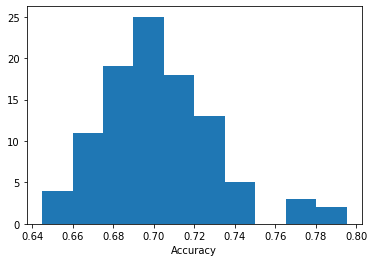

In [113]:
plt.figure()
plt.hist(accs_avg)
plt.xlabel('Accuracy')